In [1]:
import rnn, vae, config
import torch
import numpy as np
import matplotlib.pyplot as plt
import train_rnn
import train_vae
import json

In [2]:
state_vars_to_predict=[9, 10, 11]
detach_gradients = True
truncate_at_batch = 40
use_layernorm = True
random_index = 1
rnn_id = f"dg{1 if detach_gradients else 0}_ln{1 if use_layernorm else 0}_da{truncate_at_batch}_dv{len(state_vars_to_predict)}_r{random_index}"
dim_latent_z = 8

with open(f'data/rnn{rnn_id}/rnn_meta.json', "r") as in_file:
    rnn_meta = json.loads(in_file.read())
state_vars_to_predict = rnn_meta['state_vars_to_predict']

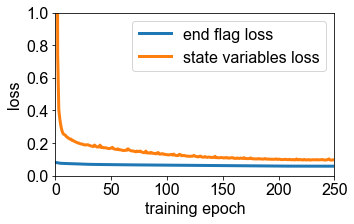

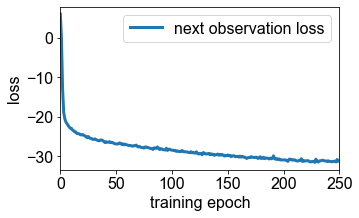

In [20]:
losses_store = np.load(f'data/rnn{rnn_id}/rnn_losses.npz')['losses_store']

plt.rcParams.update({'font.family': 'Arial', 'font.size': 16})
plt.figure(figsize=(5, 3))  # Adjust the figure size as needed
plt.plot(np.mean(losses_store, axis=1)[:, 1], linewidth=3, label="end flag loss")
plt.plot(np.mean(losses_store, axis=1)[:, 2], linewidth=3, label="state variables loss")
plt.ylim(0, 1)
plt.xlim(0, 250)
plt.legend()
plt.xlabel("training epoch")
plt.ylabel("loss")
plt.show()

plt.figure(figsize=(5, 3))  # Adjust the figure size as needed
plt.plot(np.mean(losses_store, axis=1)[:, 0], linewidth=3, label="next observation loss")
plt.legend()
plt.xlim(0, 250)
plt.xlabel("training epoch")
plt.ylabel("loss")
plt.show()

In [6]:
vae_model = vae.VAE(latent_dim=dim_latent_z).to(config.device)
vae_model.load_state_dict(torch.load(f"data/vae_model_{dim_latent_z}dimlatent.pt", map_location=config.device))

epoch = 150
rnn_model = rnn.MDNRNN(dim_latent_z, state_vars_to_predict=state_vars_to_predict, use_layernorm=use_layernorm).to(config.device)
rnn_model.load_state_dict(torch.load(f'data/rnn{rnn_id}/rnn_model_epoch{epoch}.pt', map_location=config.device))

<All keys matched successfully>

In [7]:
batch_size = 256
n_batches, mean_batches, var_batches, state_vars_batches, \
    action_batches, mask_batches, end_flag_batches = \
    train_rnn.load_data(f'data/vae_preprocessed_{dim_latent_z}dimlatent.npz', 
                                        f'data/vae_rollouts_env_vars.npz', batch_size = batch_size,
                       truncate_at_batch=truncate_at_batch)

In [8]:
batch_i=2
end_flags = end_flag_batches[batch_i]
episode_len = torch.nonzero(end_flags)[:, 1]
torch.argsort(episode_len)[0]
innerbatch_i = torch.argsort(episode_len)[-2]
max_timestep = 100
means = mean_batches[batch_i]
vars = var_batches[batch_i]
actions = action_batches[batch_i]
masks = mask_batches[batch_i][1:]
state_vars = state_vars_batches[batch_i][:1]
z_values = train_vae.reparameterization(means, vars)
inputs = torch.cat([z_values, actions], dim=2)[:, :-1]

In [9]:
hidden = rnn_model.init_hidden(batch_size)
(pi, mu, sigma), ef, hidden, _ = rnn_model(inputs, hidden)
n_gaussians = rnn_model.n_gaussians
#z_values_rec = torch.sum(train_vae.reparameterization(mu, sigma)*pi.unsqueeze(3), dim=2)
n_timesteps = pi.shape[1]
sampled_indices = torch.multinomial(pi[:, :, :].reshape(-1, n_gaussians), 1).reshape(batch_size, n_timesteps, 1, 1).repeat(1, 1, 1, dim_latent_z)
#sampled_indices = torch.max(pi[:, :, :], dim=2)[1].reshape(batch_size, n_timesteps, 1, 1).repeat(1, 1, 1, dim_latent_z)
mu_sampled = torch.gather(mu, 2, sampled_indices)
sigma_sampled = torch.gather(sigma, 2, sampled_indices)
z_values_rec = train_vae.reparameterization(mu_sampled, sigma_sampled).reshape(batch_size, n_timesteps, dim_latent_z)

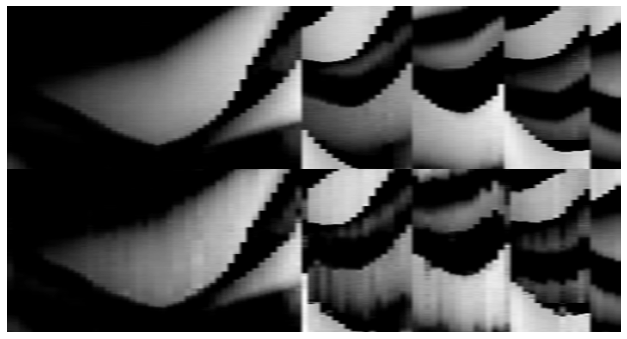

In [10]:
img_rec = vae_model.decode(z_values_rec)[innerbatch_i].cpu().detach().numpy()[:max_timestep]
img_real = vae_model.decode(z_values[:, 1:])[innerbatch_i].cpu().detach().numpy()[:max_timestep]
img = np.concatenate([img_real.T, img_rec.T])

# Display the barcode tensor as an image using Matplotlib
plt.figure(figsize=(9, 5))  # Adjust the figure size as needed
plt.imshow(img, cmap='binary', aspect='auto')
plt.axis('off')
plt.tight_layout()
plt.show()

(-4.95, 103.95, 0.0, 1.0)

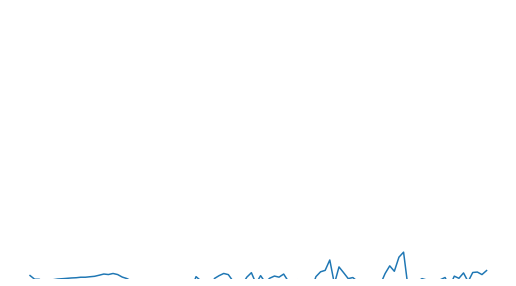

In [11]:
plt.figure(figsize=(9, 5))
plt.plot(ef[innerbatch_i, :max_timestep].reshape(-1).detach().cpu().numpy())
plt.ylim(0, 1)
plt.axis('off')

In [16]:
num_timesteps = means.shape[1]
midline = max_timestep // 3

out_z_t_store = []
hidden = rnn_model.init_hidden(batch_size)
for t in range(midline):
    inputs_t = inputs[:, t:t+1, :]
    train_rnn.detach(hidden)
    (pi, mu, sigma), ef, hidden, _ = rnn_model(inputs_t, hidden)
    
    n_timesteps = pi.shape[1]
    sampled_indices = torch.multinomial(pi[:, :, :].reshape(-1, n_gaussians), 1).reshape(batch_size, n_timesteps, 1, 1).repeat(1, 1, 1, dim_latent_z)
    #sampled_indices = torch.max(pi[:, :, :], dim=2)[1].reshape(batch_size, n_timesteps, 1, 1).repeat(1, 1, 1, dim_latent_z)
    mu_sampled = torch.gather(mu, 2, sampled_indices)
    sigma_sampled = torch.gather(sigma, 2, sampled_indices)
    out_z_t = train_vae.reparameterization(mu_sampled, sigma_sampled).reshape(batch_size, n_timesteps, dim_latent_z)
    #out_z_t = torch.sum(train_vae.reparameterization(mu, sigma)*pi, dim=2)
    #out_z_t = torch.sum(train_vae.reparameterization(mu, sigma)*pi.unsqueeze(3), dim=2)
    out_z_t_store.append(out_z_t.detach())
for t in range(midline, num_timesteps-1):
    inputs_t = torch.cat([out_z_t_store[-1], actions[:, t:t+1, :]], dim=2)
    train_rnn.detach(hidden)
    (pi, mu, sigma), ef, hidden, _ = rnn_model(inputs_t, hidden)
    
    n_timesteps = pi.shape[1]
    sampled_indices = torch.multinomial(pi[:, :, :].reshape(-1, n_gaussians), 1).reshape(batch_size, n_timesteps, 1, 1).repeat(1, 1, 1, dim_latent_z)
    #sampled_indices = torch.max(pi[:, :, :], dim=2)[1].reshape(batch_size, n_timesteps, 1, 1).repeat(1, 1, 1, dim_latent_z)
    mu_sampled = torch.gather(mu, 2, sampled_indices)
    sigma_sampled = torch.gather(sigma, 2, sampled_indices)
    out_z_t = train_vae.reparameterization(mu_sampled, sigma_sampled).reshape(batch_size, n_timesteps, dim_latent_z)

    #out_z_t = torch.sum(train_vae.reparameterization(mu, sigma)*pi, dim=2)
    #out_z_t = torch.sum(train_vae.reparameterization(mu, sigma)*pi.unsqueeze(3), dim=2)
    out_z_t_store.append(out_z_t.detach())

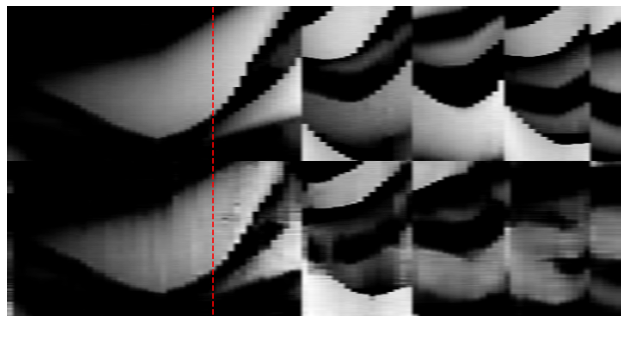

In [17]:
z_values_rec = torch.cat(out_z_t_store, dim=1)
img_rec = vae_model.decode(z_values_rec)[innerbatch_i].cpu().detach().numpy()[:max_timestep]
img_real = vae_model.decode(z_values[:, 1:])[innerbatch_i].cpu().detach().numpy()[:max_timestep]

img = np.concatenate([img_real.T, img_rec.T])

# Display the barcode tensor as an image using Matplotlib
plt.figure(figsize=(9, 5))  # Adjust the figure size as needed
plt.imshow(img, cmap='binary', aspect='auto')
plt.plot([midline, midline], [0, 360], "r--")
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
def sample_z_from_mdn_output(pi, mu, sigma):
    n_timesteps = pi.shape[1]
    sampled_indices = torch.multinomial(pi[:, :, :, :].transpose(2, 3).reshape(-1, n_gaussians), 1).reshape(batch_size, n_timesteps, 1, dim_latent_z)
    mu_sampled = torch.gather(mu, 2, sampled_indices)
    sigma_sampled = torch.gather(sigma, 2, sampled_indices)
    train_vae.reparameterization(mu_sampled, sigma_sampled).reshape(batch_size, 1, dim_latent_z).shape

# Training linear probes

In [145]:
def get_losses(rnn_model):
    batch_size = mean_batches[0].shape[0]
    hidden_batches = []
    for batch_i in range(n_batches):
        hidden = rnn_model.init_hidden(batch_size)
    
        means = mean_batches[batch_i]
        vars = var_batches[batch_i]
        actions = action_batches[batch_i]
        masks = mask_batches[batch_i][:, 1:]
        end_flags = end_flag_batches[batch_i]
        state_vars = state_vars_batches[batch_i][:, :-1]
        z_values = train_vae.reparameterization(means, vars)
        inputs = torch.cat([z_values[:, :-1], actions[:, :-1]], dim=2)  # [:, :-1]
        
        # hidden = detach(hidden)
        (pi, mu, sigma), ef, hidden, y = rnn_model(inputs, hidden)
        hidden_batches.append(y.detach())
    
    linear_model = torch.nn.Linear(hidden_batches[0].shape[2], state_vars_batches[0].shape[2])
    optimizer = torch.optim.Adam(linear_model.parameters())#, lr=0.001)
    
    n_epochs = 50
    for epoch in range(n_epochs):
        # Set initial hidden and cell states
        for batch_i in range(n_batches):
            masks = mask_batches[batch_i][:, 1:]
            state_vars = state_vars_batches[batch_i][:, :-1]
            hidden_states = hidden_batches[batch_i][:, :]
    
            state_vars_pred = linear_model(hidden_states)
            loss = torch.mean((state_vars_pred - state_vars)**2 * masks.unsqueeze(2))
    
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            #if (epoch + 1) % 10 == 0: print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}")
    
    loss = 0
    loss_denom = 0
    with torch.no_grad():
        for batch_i in range(n_batches):
            masks = mask_batches[batch_i][:, 1:]
            state_vars = state_vars_batches[batch_i][:, :-1]
            hidden_states = hidden_batches[batch_i][:, :]
    
            state_vars_pred = linear_model(hidden_states)
            loss += torch.sum((state_vars_pred - state_vars)**2 * masks.unsqueeze(2), dim=[0,1])
            loss_denom += torch.sum(masks).item()
    return loss / loss_denom

In [146]:
rnn_epochs = [50, 100, 200, 300, 400, 500]
losses_stores = []
for rnn_epoch in rnn_epochs:
    rnn_model = rnn.MDNRNN(dim_latent_z, state_vars_to_predict=state_vars_to_predict).to(config.device)
    rnn_model.load_state_dict(torch.load(f'data/rnn{rnn_id}/rnn_model_epoch{rnn_epoch}.pt', map_location=config.device))
    print(rnn_epoch)
    losses_stores.append(get_losses(rnn_model))

50
100
200
300
400
500


In [40]:
state_variables_names =  [
    "the last pipe's horizontal position",
    "the last top pipe's vertical position",
    "the last bottom pipe's vertical position",
    "the next pipe's horizontal position",
    "the next top pipe's vertical position",
    "the next bottom pipe's vertical position",
    "the next next pipe's horizontal position",
    "the next next top pipe's vertical position",
    "the next next bottom pipe's vertical position",
    "player's vertical position",
    "player's vertical velocity",
    "player's rotation",
]

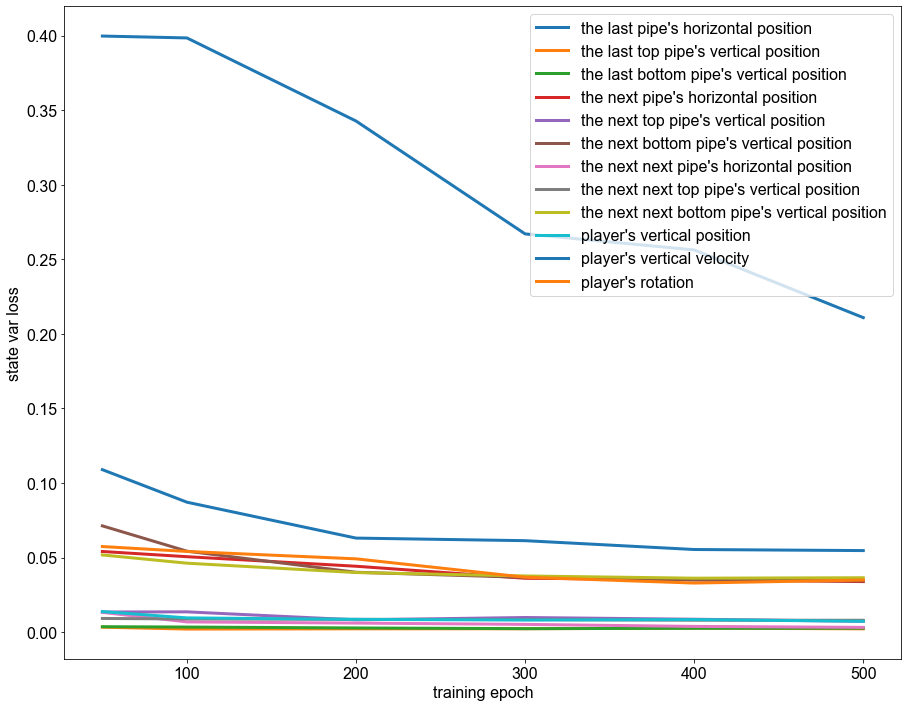

In [148]:
plt.rcParams.update({'font.family': 'Arial', 'font.size': 16})
plt.figure(figsize=(15, 12))  # Adjust the figure size as needed
for i, name in enumerate(state_variables_names):
    plt.plot(rnn_epochs, [losses_store[i] for losses_store in losses_stores], linewidth=3, label=state_variables_names[i])
plt.legend()
plt.xlabel("training epoch")
plt.ylabel("state var loss")
plt.show()

In [36]:
batch_size = mean_batches[0].shape[0]
hidden_batches = []
for batch_i in range(n_batches):
    hidden = rnn_model.init_hidden(batch_size)

    means = mean_batches[batch_i]
    vars = var_batches[batch_i]
    actions = action_batches[batch_i]
    masks = mask_batches[batch_i][:, 1:]
    end_flags = end_flag_batches[batch_i]
    state_vars = state_vars_batches[batch_i][:, :-1]
    z_values = train_vae.reparameterization(means, vars)
    inputs = torch.cat([z_values[:, :-1], actions[:, :-1]], dim=2)  # [:, :-1]
    
    # hidden = detach(hidden)
    (pi, mu, sigma), ef, hidden, y = rnn_model(inputs, hidden)
    hidden_batches.append(y.detach())

linear_model = torch.nn.Linear(hidden_batches[0].shape[2], state_vars_batches[0].shape[2])
optimizer = torch.optim.Adam(linear_model.parameters())#, lr=0.001)

n_epochs = 50
for epoch in range(n_epochs):
    # Set initial hidden and cell states
    for batch_i in range(n_batches):
        masks = mask_batches[batch_i][:, 1:]
        state_vars = state_vars_batches[batch_i][:, :-1]
        hidden_states = hidden_batches[batch_i][:, :]

        state_vars_pred = linear_model(hidden_states)
        loss = torch.mean((state_vars_pred - state_vars)**2 * masks.unsqueeze(2))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 10 == 0: print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}")

loss = 0
loss_denom = 0
with torch.no_grad():
    for batch_i in range(n_batches):
        masks = mask_batches[batch_i][:, 1:]
        state_vars = state_vars_batches[batch_i][:, :-1]
        hidden_states = hidden_batches[batch_i][:, :]

        state_vars_pred = linear_model(hidden_states)
        loss += torch.sum((state_vars_pred - state_vars)**2 * masks.unsqueeze(2), dim=[0,1])
        loss_denom += torch.sum(masks).item()
return loss / loss_denom

Epoch [10/50], Loss: 0.0034
Epoch [10/50], Loss: 0.0033
Epoch [10/50], Loss: 0.0037
Epoch [10/50], Loss: 0.0031
Epoch [10/50], Loss: 0.0024
Epoch [10/50], Loss: 0.0021
Epoch [10/50], Loss: 0.0035
Epoch [10/50], Loss: 0.0031
Epoch [10/50], Loss: 0.0029
Epoch [10/50], Loss: 0.0035
Epoch [10/50], Loss: 0.0030
Epoch [10/50], Loss: 0.0027
Epoch [10/50], Loss: 0.0030
Epoch [10/50], Loss: 0.0019
Epoch [10/50], Loss: 0.0030
Epoch [10/50], Loss: 0.0029
Epoch [10/50], Loss: 0.0027
Epoch [10/50], Loss: 0.0023
Epoch [10/50], Loss: 0.0025
Epoch [10/50], Loss: 0.0027
Epoch [10/50], Loss: 0.0018
Epoch [10/50], Loss: 0.0022
Epoch [10/50], Loss: 0.0034
Epoch [10/50], Loss: 0.0026
Epoch [10/50], Loss: 0.0035
Epoch [10/50], Loss: 0.0026
Epoch [10/50], Loss: 0.0030
Epoch [10/50], Loss: 0.0028
Epoch [10/50], Loss: 0.0027
Epoch [10/50], Loss: 0.0028
Epoch [10/50], Loss: 0.0029
Epoch [10/50], Loss: 0.0019
Epoch [10/50], Loss: 0.0022
Epoch [10/50], Loss: 0.0028
Epoch [10/50], Loss: 0.0029
Epoch [10/50], Loss:

SyntaxError: 'return' outside function (1938183385.py, line 50)

In [37]:
batch_i = 0
masks = mask_batches[batch_i][:, 1:]
state_vars = state_vars_batches[batch_i][:, :-1]
hidden_states = hidden_batches[batch_i][:, :]

state_vars_pred = linear_model(hidden_states)

In [38]:
state_vars[0, :, -1].shape

torch.Size([513])

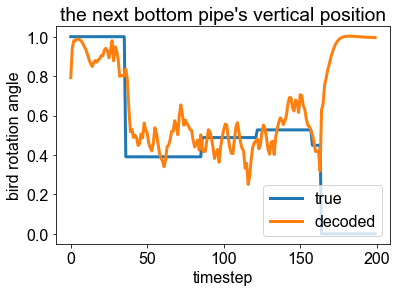

In [53]:
i = 5
print()
plt.rcParams.update({'font.family': 'Arial', 'font.size': 16})
plt.figure(figsize=(6, 4))  # Adjust the figure size as needed
plt.plot(state_vars[0, :200, i], linewidth=3, label="true")
plt.plot(state_vars_pred[0, :200, i].cpu().detach().numpy(), linewidth=3, label="decoded")
plt.legend(loc=4)
plt.xlabel("timestep")
plt.ylabel("bird rotation angle")
plt.title(state_variables_names[i])
plt.show()
